In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import re

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(891, 12)
(418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Analysis

In [4]:
# CHecking for null values and data types
train_df.isnull().sum(), train_df.isnull().sum()

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64)

In [5]:
train_df.Cabin.value_counts(), train_df.Embarked.value_counts()

(Cabin
 G6             4
 C23 C25 C27    4
 B96 B98        4
 F2             3
 D              3
               ..
 E17            1
 A24            1
 C50            1
 B42            1
 C148           1
 Name: count, Length: 147, dtype: int64,
 Embarked
 S    644
 C    168
 Q     77
 Name: count, dtype: int64)

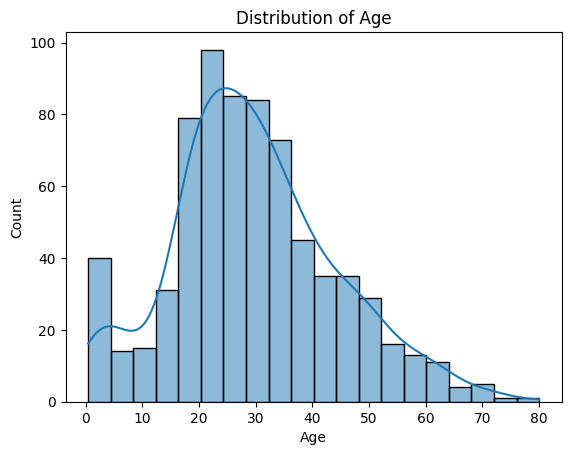

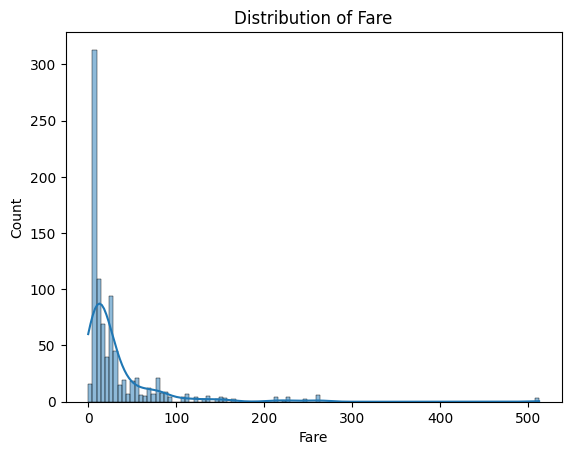

In [6]:
for col in ["Age", "Fare"]:
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

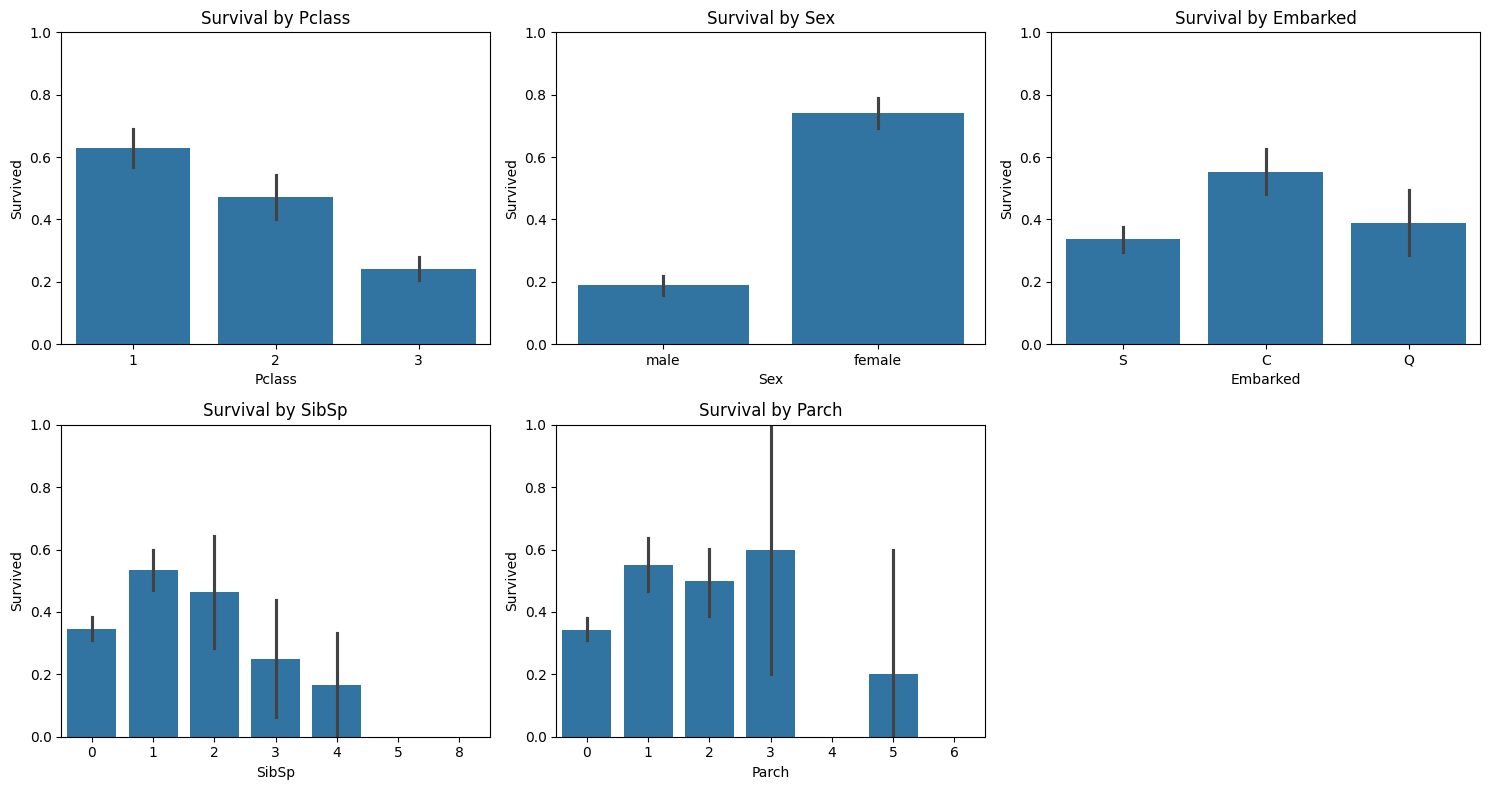

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(["Pclass", "Sex", "Embarked", "SibSp", "Parch"]):
    sns.barplot(x=col, y="Survived", data=train_df, ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"Survival by {col}")

# Remove the extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [8]:
def get_cab_number(cabin_val):
    if type(cabin_val) is str:
        cabin_int = re.findall(r"\d+", cabin_val)
        cabin_int = [int(x) for x in cabin_int]
        if cabin_int:
            return max(cabin_int)
    return np.nan

def get_cab_char(cabin_val):
    if type(cabin_val) is str:
        if cabin_val[0].isalpha():
            return cabin_val[0]
    return np.nan

def get_title(name_val):
    matches = re.findall(r"\s\w+\.", name_val)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_marital_status(title_list):
    status = []
    for t in title_list:
        if "Mr." in t or "Mrs." in t:
            status.append(1)
        elif "Miss." in t or "Master." in t:
            status.append(0)
        else:
            status.append(-1)
    return status

Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64


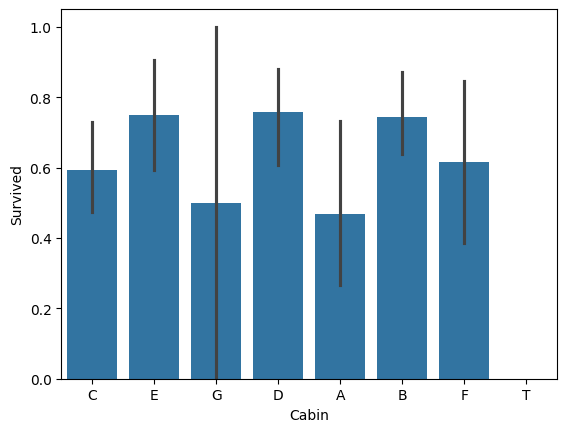

In [9]:
train_inspect_df = train_df.copy()
train_inspect_df['Cabin'] = train_df['Cabin'].map(get_cab_char)
sns.barplot(x="Cabin", y="Survived", data=train_inspect_df)
print(train_inspect_df.Cabin.value_counts())

## Data Preprocessing

In [10]:
all_names = train_df.Name.tolist() + test_df.Name.tolist()
all_words = set()

for name in all_names:
    cleand_words = re.sub(r'[^a-z\s]', '', name.lower())
    all_words.update([word for word in cleand_words.split()])
    
word_to_idx = {word: idx for idx, word in enumerate(all_words)}
name_vocab_size = len(word_to_idx)
print(f"Vocab size: {name_vocab_size}")

Vocab size: 1950


In [11]:
def prepare_sequence(seq_text, to_ix):
    seq_text = re.sub(r'[^a-z\s]', '', seq_text.lower())
    seq = seq_text.split()
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

train_names_vec = [prepare_sequence(name, word_to_idx) for name in train_df.Name]
test_names_vec = [prepare_sequence(name, word_to_idx) for name in test_df.Name]

all_names_vec = nn.utils.rnn.pad_sequence(train_names_vec + test_names_vec,
                                   padding_value=name_vocab_size,
                                   batch_first=True)

X_train_name = all_names_vec[: train_df.shape[0]]
X_test_name = all_names_vec[train_df.shape[0] : ]
X_train_name.shape

torch.Size([891, 14])

In [12]:
def preprocess_data(input_df):
    X_df = input_df.copy()

    X_df['CabinNum'] = X_df['Cabin'].map(get_cab_number)
    X_df['CabinKnown'] = np.where(X_df['Cabin'].isnull(), 0, 1)

    X_df['AgeKnown'] = np.where(X_df['Age'].isnull(), 0, 1)

    X_df.fillna({"Fare": X_df["Fare"].median(skipna=True),
                "Embarked": X_df["Embarked"].mode(dropna=True),
                "CabinNum": X_df["CabinNum"].median(skipna=True),
                "Age": X_df["Age"].median(skipna=True)
                }, inplace=True)

    title = X_df['Name'].map(get_title)
    X_df['Married'] = get_marital_status(title)

    X_df = pd.get_dummies(X_df, columns=["Pclass","Sex", "Embarked"], drop_first=True, dtype=int)

    # Dropping irrelevant features
    X_df.drop('PassengerId', axis=1, inplace=True)
    X_df.drop(['Name', 'Cabin', 'Ticket'], \
        axis=1, inplace=True)
    
    X_df.drop('Survived', axis=1, inplace=True, errors='ignore')

    return X_df

X_train_other = preprocess_data(train_df)
X_test_other = preprocess_data(test_df)

print(X_train_other.shape)
X_train_other.head()

(891, 13)


,Age,SibSp,Parch,Fare,CabinNum,CabinKnown,AgeKnown,Married,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,43.0,0,1,1,0,1,1,0,1
1,38.0,1,0,71.2833,85.0,1,1,1,0,0,0,0,0
2,26.0,0,0,7.9250,43.0,0,1,0,0,1,0,0,1
3,35.0,1,0,53.1000,123.0,1,1,1,0,0,0,0,1
4,35.0,0,0,8.0500,43.0,0,1,1,0,1,1,0,1


In [13]:
X_train_other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   CabinNum    891 non-null    float64
 5   CabinKnown  891 non-null    int64  
 6   AgeKnown    891 non-null    int64  
 7   Married     891 non-null    int64  
 8   Pclass_2    891 non-null    int64  
 9   Pclass_3    891 non-null    int64  
 10  Sex_male    891 non-null    int64  
 11  Embarked_Q  891 non-null    int64  
 12  Embarked_S  891 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 90.6 KB


## Model Building

In [14]:
# Splitting trainig and validation data
train_indices = np.random.choice(train_df.shape[0], 
                                 size=int(0.8*train_df.shape[0]), 
                                 replace=False).tolist()
val_indices = [i for i in range(len(train_df)) if i not in train_indices]

X_train_train_name = X_train_name[train_indices].to(device)
X_train_val_name = X_train_name[val_indices].to(device)

X_train_train_other = torch.tensor(X_train_other.iloc[train_indices].values, dtype=torch.float32).to(device)
X_train_val_other = torch.tensor(X_train_other.iloc[val_indices].values, dtype=torch.float32).to(device)

y_train_train = torch.tensor(train_df.iloc[train_indices]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
y_train_val = torch.tensor(train_df.iloc[val_indices]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
print(y_train_train.device)

cpu


In [15]:
torch.isnan(X_train_train_name).sum(), torch.isnan(X_train_train_other).sum(), torch.isnan(y_train_train).sum()

(tensor(0), tensor(0), tensor(0))

In [16]:
class TitanicSurvivalModel(nn.Module):
    def __init__(self, name_vocab_size, max_name_length, name_embedding_dim, other_feature_dim):
        super(TitanicSurvivalModel, self).__init__()
        self.name_embedding = nn.Embedding(name_vocab_size + 1, name_embedding_dim)
        self.fc1 = nn.Linear((name_embedding_dim * max_name_length) + other_feature_dim, 28)  # 32 for hidden dimension
        self.fc2 = nn.Linear(28, 8)
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, name_vec, other_features):
        # print("Input shapes:")
        # print(name_vec.shape, other_features.shape)

        embedded = self.name_embedding(name_vec)  # Simple average of embeddings
        # print("Embedded shape:", embedded.shape)
        embedded = torch.flatten(embedded, start_dim=1)

        x = torch.cat((embedded, other_features), dim=-1)
        # print("x shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No sigmoid - BCEWithLogitsLoss handles it
        return x

In [39]:
# Initialize the model
model = TitanicSurvivalModel(name_vocab_size = name_vocab_size, 
                             max_name_length = X_train_name.shape[1], 
                             name_embedding_dim = 5, 
                             other_feature_dim = X_train_other.shape[1])

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # More numerically stable than BCELoss + sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Model initialized with:")
print(f"\nModel architecture:\n{model}")
print("# model parameters: ", sum([p.numel() for p in model.parameters()]))

Model initialized with:

Model architecture:
TitanicSurvivalModel(
  (name_embedding): Embedding(1951, 5)
  (fc1): Linear(in_features=83, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
# model parameters:  12348


In [40]:
def model_accuracy(model, name_vec, other_features, labels, print_report=False):
    model.eval()
    with torch.no_grad():
        outputs = model(name_vec, other_features)
        predicted = (F.sigmoid(outputs) >= 0.5).float()  # Apply sigmoid for prediction
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        if print_report:
            print(classification_report(labels.cpu(), predicted.cpu()))

    return accuracy

In [41]:
# Early stopping: prevents overfitting by stopping when validation accuracy plateaus
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience  # Wait this many checks before stopping
        self.min_delta = min_delta  # Minimum improvement threshold
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        self.best_state_dict = None  # To save the best model weights
        
    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.best_state_dict = model.state_dict()

        elif val_acc > self.best_score + self.min_delta:
            self.best_score = val_acc
            self.best_state_dict = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [42]:
# Model before training
model_accuracy(model, X_train_val_name, X_train_val_other, y_train_val, print_report=True)

              precision    recall  f1-score   support

         0.0       0.67      0.96      0.79       114
         1.0       0.71      0.15      0.25        65

    accuracy                           0.67       179
   macro avg       0.69      0.56      0.52       179
weighted avg       0.68      0.67      0.59       179



0.6703910614525139

In [43]:
# Training loop
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=5, min_delta=0.0002)
model.to(device)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    model.train()
    indices = torch.randperm(len(X_train_train_name), generator=torch.Generator().manual_seed(epoch))
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        
        name_vec = X_train_train_name[batch_indices]
        other_features = X_train_train_other[batch_indices]
        target = y_train_train[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(name_vec, other_features)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / (len(X_train_train_name) / batch_size)
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_val_name, X_train_val_other)
        val_loss = criterion(val_outputs, y_train_val)
        train_acc = model_accuracy(model, X_train_train_name, X_train_train_other, y_train_train)
        val_acc = model_accuracy(model, X_train_val_name, X_train_val_other, y_train_val)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_acc, model=model)
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed!")

Epoch [1/100], Train Loss: 0.6999, Val Loss: 0.6286, Train Acc: 0.6517, Val Acc: 0.6592
Epoch [2/100], Train Loss: 0.6912, Val Loss: 0.6087, Train Acc: 0.6657, Val Acc: 0.6983
Epoch [3/100], Train Loss: 0.6662, Val Loss: 0.5979, Train Acc: 0.6699, Val Acc: 0.6983
Epoch [4/100], Train Loss: 0.6478, Val Loss: 0.5897, Train Acc: 0.6728, Val Acc: 0.6927
Epoch [5/100], Train Loss: 0.6445, Val Loss: 0.5817, Train Acc: 0.6798, Val Acc: 0.7039
Epoch [6/100], Train Loss: 0.6541, Val Loss: 0.5735, Train Acc: 0.6840, Val Acc: 0.7151
Epoch [7/100], Train Loss: 0.6398, Val Loss: 0.5711, Train Acc: 0.6840, Val Acc: 0.7095
Epoch [8/100], Train Loss: 0.6243, Val Loss: 0.5621, Train Acc: 0.6854, Val Acc: 0.7151
Epoch [9/100], Train Loss: 0.6090, Val Loss: 0.5570, Train Acc: 0.6882, Val Acc: 0.7207
Epoch [10/100], Train Loss: 0.6172, Val Loss: 0.5498, Train Acc: 0.6896, Val Acc: 0.7263
Epoch [11/100], Train Loss: 0.5906, Val Loss: 0.5456, Train Acc: 0.6938, Val Acc: 0.7318
Epoch [12/100], Train Loss: 0.

In [36]:
best_model = TitanicSurvivalModel(name_vocab_size = name_vocab_size, 
                                 max_name_length = X_train_name.shape[1], 
                                 name_embedding_dim = 5, 
                                 other_feature_dim = X_train_other.shape[1])
best_model.load_state_dict(early_stopping.best_state_dict)
best_model.to(device)
print("\nBest model performance on validation set:")
model_accuracy(best_model, X_train_val_name, X_train_val_other, y_train_val)


Best model performance on validation set:


0.8156424581005587